# Analysis of Abundance Data (aka Fitting Models to Abundance Data) <a class="tocSkip">

<!--NAVIGATION-->

<[Back to Workshop Contents](Index.ipynb)>

<div id="toc"> </div>

## Introduction

### Why Abundances?

Fluctuations in the abundance (density) of a disease's vector play a crucial role in its transmission dynamics. This is especially true if vector population densities or their [traits](Traits.ipynb) change at the same or shorter timescales than the rate of disease transmission. Indeed, most vectors are small ectotherms with short generation times and greater sensitivity to environmental conditions than their (invariably larger, longer-lived, and often, endothermic) hosts. So understanding how vector populations vary over time and space is key. 

This section of the training workshop is focused on teaching some techniques for analysis of abundance data. These techniques can also be applies to the analysis of variation in disease incidence, as you will try in the Challenge problem.

As we did in the [Traits](Traits.ipynb) workshop, we will work with a mixture of techniques here:  NLLS, Maximum likelihood and Bayesian fitting.  

In [1]:
rm(list = ls())
graphics.off()
library("ggplot2")
library(repr)
options(repr.plot.width=6, repr.plot.height=5) # Change default plot size; not necessary if you are using Rstudio
library(minpack.lm)

## Population growth rate

In general, a population grows exponentially while its abundance is low and resources are not limiting. This growth then slows and eventually stops as resources become limiting. There may also be a time lag before the population growth really takes off at the start. We will focus on microbial (specifically, bacterial) growth rates. Bacterial growth in batch culture follows a distinct set of phases; lag phase, exponential phase and stationary phase. During the lag phase a suite of transcriptional machinery is activated, including genes involved in nutrient uptake and metabolic changes, as bacteria prepare for growth. During the exponential growth phase, bacteria divide at a constant rate, the population doubling with each generation. When the carrying capacity of the media is reached, growth slows and the number of cells in the culture stabilises, beginning the stationary phase.

Traditionally, growth rate can be measured by plotting out cell numbers or culture density against time on a semi-log graph and fitting a straight line through the exponential growth phase - the slope of the line gives the maximum growth rate ($r_{max}$). Models have since been devised which we can use to describe the whole sigmoidal bacterial growth curve. 

Let's first generate some "data" on the number of bacterial cells as a function of time that we can play with:

In [2]:
time <- c(0, 2, 4, 6, 8, 10, 12, 16, 20, 24) # timepoints, in hours
log_cells <- c(3.62, 3.62, 3.63, 4.14, 5.23, 6.27, 7.57, 8.38, 8.70, 8.69) # logged cell counts - more on this below

data <- data.frame(time, log_cells) + rnorm(length(time),sd=.1) # add some random error

names(data) <- c("t", "LogN")

We have added a vector of normally distributed errors to emulate random "sampling errors". Note also that the the assumption of normality of these errors underlies the statistical analyses of Ordinary NLLS fits just as it underies Ordinary Least Squares (your standard linear modelling).

Plot the data:

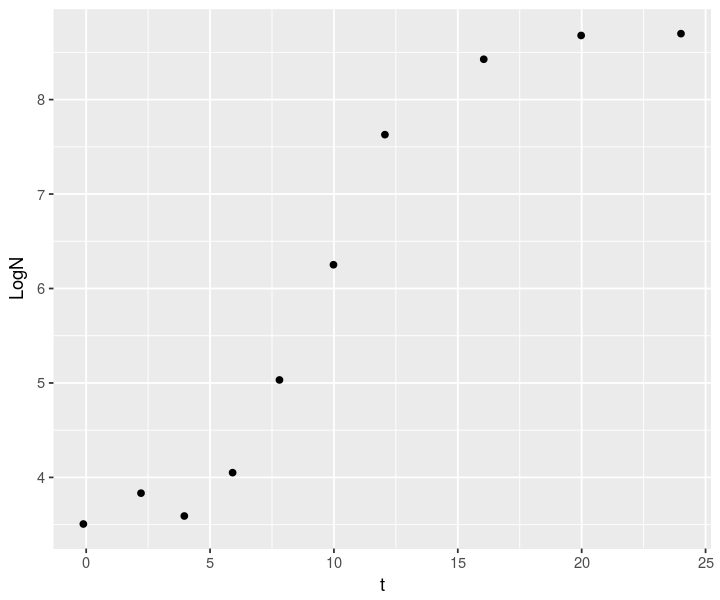

In [3]:
ggplot(data, aes(x = t, y = LogN)) + geom_point()

We will fit three growth models, all of which are known to fit such population growth data, especially in microbes. These are a modified Gompertz model (Zwietering et. al., 1990), the Baranyi model (Baranyi, 1993) and the Buchanan model (or three-phase logistic model; Buchanan, 1997). Given a set of cell numbers (N) and times (t), each growth model can be described in terms of:

$N_0$:  Initial cell culture (Population) density (number of cells per unit volume)  

$N_{max}$: Maximum culture density (aka "carrying capacity") 

$r_{max}$: Maximum growth rate 

$t_{lag}$: Duration of the lag phase before the population starts growing exponentially
   
First let's specify the model functions:

In [4]:
baranyi_model <- function(t, r_max, N_max, N_0, t_lag){  # Baranyi model (Baranyi 1993)
return(N_max + log10((-1+exp(r_max*t_lag) + exp(r_max*t))/(exp(r_max*t) - 1 + exp(r_max*t_lag) * 10^(N_max-N_0))))
}


buchanan_model <- function(t, r_max, N_max, N_0, t_lag){ # Buchanan model - three phase logistic (buchanan 1997)
  return(N_0 + (t >= t_lag) * (t <= (t_lag + (N_max - N_0) * log(10)/r_max)) * r_max * (t - t_lag)/log(10) +
           (t >= t_lag) * (t > (t_lag + (N_max - N_0) * log(10)/r_max)) * (N_max - N_0))
}


gompertz_model <- function(t, r_max, N_max, N_0, t_lag){  # Modified gompertz growth model (Zwietering 1990)
  return(N_0 + (N_max - N_0) * exp(-exp(r_max * exp(1) * (t_lag - t)/((N_max - N_0) * log(10)) + 1)))
}


It is important to note that we have written the funcions in log (to the base 10 - can also be base 2 or natural log) scale. This is because NLLS fitting often converges better in log scale. The interpretation of each of the the estimated/fitted paramters does not change if we take a log of the model's equation.    

Now let's generate some starting values for the NLLS fitting. We did not pay much attention to what starting values we used in the above example on fitting an allometric model because the power-law model is easy to fit using NLLS, and starting far from the optimal parameters does not matter too much. Here, we derive the starting values by using the actual data:  

In [5]:
N_0_start <- min(data$LogN)
N_max_start <- max(data$LogN)
t_lag_start <- data$t[which.max(diff(diff(data$LogN)))]
r_max_start <- max(diff(data$LogN))/mean(diff(data$t))

Now fit the models:

In [6]:
fit_baranyi <- nlsLM(LogN ~ baranyi_model(t = t, r_max, N_max, N_0, t_lag), data,
              list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

fit_buchanan <- nlsLM(LogN ~ buchanan_model(t = t, r_max, N_max, N_0, t_lag), data,
                        list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

fit_gompertz <- nlsLM(LogN ~ gompertz_model(t = t, r_max, N_max, N_0, t_lag), data,
                      list(t_lag=t_lag_start, r_max=r_max_start, N_0 = N_0_start, N_max = N_max_start))

You might get a warning message such as:

`Warning message in baranyi_model(t = t, r_max, N_max, N_0, t_lag):
“NaNs produced”`

This just means that the Baranyi model generated some NaNs during the fitting procedure for the given data. You can ignore it in this case (but not always - sometimes these NaNs mean that the equation is wrongly written, or that it generates NaNs across the whole range of the x-values, in which case the model is inappropriate for these data).     

Get the model summaries:

In [7]:
summary(fit_baranyi)
summary(fit_buchanan)
summary(fit_gompertz)


Formula: LogN ~ baranyi_model(t = t, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  5.62004    0.33095   16.98 2.67e-06 ***
r_max  1.42376    0.08931   15.94 3.87e-06 ***
N_0    3.63411    0.08193   44.35 8.79e-09 ***
N_max  8.60955    0.08007  107.53 4.36e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1369 on 6 degrees of freedom

Number of iterations to convergence: 10 
Achieved convergence tolerance: 1.49e-08



Formula: LogN ~ buchanan_model(t = t, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  5.32372    0.27221   19.56 1.16e-06 ***
r_max  1.33581    0.07204   18.54 1.59e-06 ***
N_0    3.64379    0.08333   43.73 9.58e-09 ***
N_max  8.60134    0.08333  103.22 5.57e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1443 on 6 degrees of freedom

Number of iterations to convergence: 9 
Achieved convergence tolerance: 1.49e-08



Formula: LogN ~ gompertz_model(t = t, r_max, N_max, N_0, t_lag)

Parameters:
      Estimate Std. Error t value Pr(>|t|)    
t_lag  5.86615    0.31492   18.63 1.54e-06 ***
r_max  1.57009    0.11503   13.65 9.60e-06 ***
N_0    3.65030    0.08252   44.23 8.94e-09 ***
N_max  8.75717    0.10215   85.73 1.70e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1406 on 6 degrees of freedom

Number of iterations to convergence: 8 
Achieved convergence tolerance: 1.49e-08


And see how the fits look:

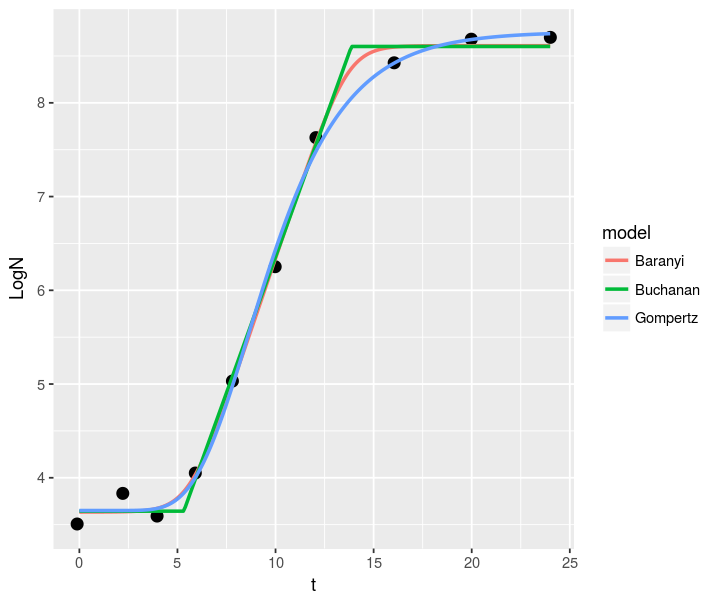

In [8]:
timepoints <- seq(0, 24, 0.1)

baranyi_points <- baranyi_model(t = timepoints, r_max = coef(fit_baranyi)["r_max"], N_max = coef(fit_baranyi)["N_max"], N_0 = coef(fit_baranyi)["N_0"], t_lag = coef(fit_baranyi)["t_lag"])

buchanan_points <- buchanan_model(t = timepoints, r_max = coef(fit_buchanan)["r_max"], N_max = coef(fit_buchanan)["N_max"], N_0 = coef(fit_buchanan)["N_0"], t_lag = coef(fit_buchanan)["t_lag"])

gompertz_points <- gompertz_model(t = timepoints, r_max = coef(fit_gompertz)["r_max"], N_max = coef(fit_gompertz)["N_max"], N_0 = coef(fit_gompertz)["N_0"], t_lag = coef(fit_gompertz)["t_lag"])

df1 <- data.frame(timepoints, baranyi_points)
df1$model <- "Baranyi"
names(df1) <- c("t", "LogN", "model")

df2 <- data.frame(timepoints, buchanan_points)
df2$model <- "Buchanan"
names(df2) <- c("t", "LogN", "model")

df3 <- data.frame(timepoints, gompertz_points)
df3$model <- "Gompertz"
names(df3) <- c("t", "LogN", "model")

model_frame <- rbind(df1, df2, df3)

ggplot(data, aes(x = t, y = LogN)) +
  geom_point(size = 3) +
  geom_line(data = model_frame, aes(x = t, y = LogN, col = model), size = 1)

#### Exercises

(a) Calculate the confidence intervals on the parameters of each of the three fitted models, and use model selection (using AIC and/or BIC) as you did before to find the best-fitting model of the three

(b) Repeat the model comparison exercise 1000 times (You will have to write a loop), and determine whether one model generally wins more often than the others. Note that each run will generate a slightly different dataset, because we are adding a vector of random errors every time the "data" are generated.

(c) Repeat (b), but increase the error by increasing the standard deviation of the normal error distributon, and see if there are differences in the robustness of the models to sampling/experimental errors. You may also want to try changing the distribution of the errors to some non-normal distribution and see what happens.

### Practical

Fit some real data to these models! These data have been generated/collected by [Tom Smith](https://mhasoba.pythonanywhere.com/pawarlab/default/people), a PhD student at Silwood as part of his Dissertation research. Import the [dataset](https://github.com/mhasoba/TheMulQuaBio/blob/master/Data/example_growth_data.csv) into R: 

In [9]:
BacData <- read.csv("../data/example_growth_data.csv")

head(BacData)
tail(BacData)

ID,bacterial_genus,replicate,trait_name,trait_value,hour
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),5.301030,0
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),5.301030,5
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),6.991226,10
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),8.094820,15
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),8.358316,20
Sch_AE103_02,Flavobacterium,1,Log(cells/mL),8.460296,25


,ID,bacterial_genus,replicate,trait_name,trait_value,hour
963,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.086360,25
964,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.322219,30
965,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.361728,35
966,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.322219,40
967,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.260071,45
968,Wil_SP04_02,Bacillus,4,Log(cells/mL),7.292256,50


The column `trait_value` and `hour` are your variables of interest (log cell density and time), respectively. Note that the `ID` column will tell you which rows represent one separate growth experiment.  Make sure you have a good look at the data first by plotting them up (idealy, in a loop).  

1. Fit the above population growth rate models, and perform model selection on them. Which model fits best? 
* Can you think of a difefrent model to fit? If so, implement it, and compare that as well. 
* Write the analysis as a single self-standing R script, which will run and return the results in a `*.csv` file and plot(s) ins pdf.
* Again, consider using ggplot insted of base plotting.

## A Bayesian analysis

We will now perform a bayesian analysis of population growth data.   

In [10]:
require(R2jags) # does the fitting
require(coda) # makes diagnostic plots
library(IDPmisc) # makes nice colored pairs plots to look at joint posteriors

Loading required package: R2jags
Loading required package: rjags
Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs

Attaching package: ‘R2jags’

The following object is masked from ‘package:coda’:

    traceplot

Loading required package: grid
Loading required package: lattice


### The Data

These data are observations of the amphibian fungal pathogen  _Batrachochytrium dendrobatidis_ being grown in liquid culture at multiple different temperatures. The experiment is conducted in 96 well plates with a fixed initial innoculation of fungal spores in each well, and the plate placed in a constant temperature incubator. Each day, 8 wells per plate are observed and the optical density (OD) is measured. We will focus on a single temperature trial across mulitple plates with OD as the response. 

We will fit a logistic model to these growth data. 

Let's have a look at the data first:

In [11]:
dat <- read.csv("../data/lb_ab_temps.csv")
head(dat)

X,EXP,TEMP,DAY,ISOLATE,PLATE,WELL,OD,NC_AVG,OD_SUB
1,2,5,1,LB_AB,P.16,1,0.120,0.1195,0.0005
2,2,5,1,LB_AB,P.16,2,0.120,0.1195,0.0005
3,2,5,1,LB_AB,P.16,3,0.122,0.1195,0.0025
4,2,5,1,LB_AB,P.16,4,0.123,0.1195,0.0035
5,2,5,1,LB_AB,P.16,5,0.125,0.1195,0.0055
6,2,5,1,LB_AB,P.16,6,0.125,0.1195,0.0055


We are only interested in a subset of these data, so we will subset out only those from experiment 2, and a temperature of 12$^\circ$C.

In [12]:
d2<-dat[which(dat$EXP==2),2:8]
d2<-d2[which(d2$TEMP==12),]
summary(d2)

      EXP         TEMP         DAY         ISOLATE        PLATE    
 Min.   :2   Min.   :12   Min.   : 1.00   LB_AB:730   P.11   :160  
 1st Qu.:2   1st Qu.:12   1st Qu.: 9.00               P.12   :150  
 Median :2   Median :12   Median :19.00               P.13   :150  
 Mean   :2   Mean   :12   Mean   :19.04               P.14   :140  
 3rd Qu.:2   3rd Qu.:12   3rd Qu.:29.00               P.15   :130  
 Max.   :2   Max.   :12   Max.   :39.00               P.1    :  0  
                                                      (Other):  0  
      WELL             OD        
 Min.   :1.000   Min.   :0.0930  
 1st Qu.:2.000   1st Qu.:0.1630  
 Median :4.000   Median :0.2580  
 Mean   :4.315   Mean   :0.2437  
 3rd Qu.:6.000   3rd Qu.:0.3170  
 Max.   :8.000   Max.   :0.4600  
                                 

Now plot it:

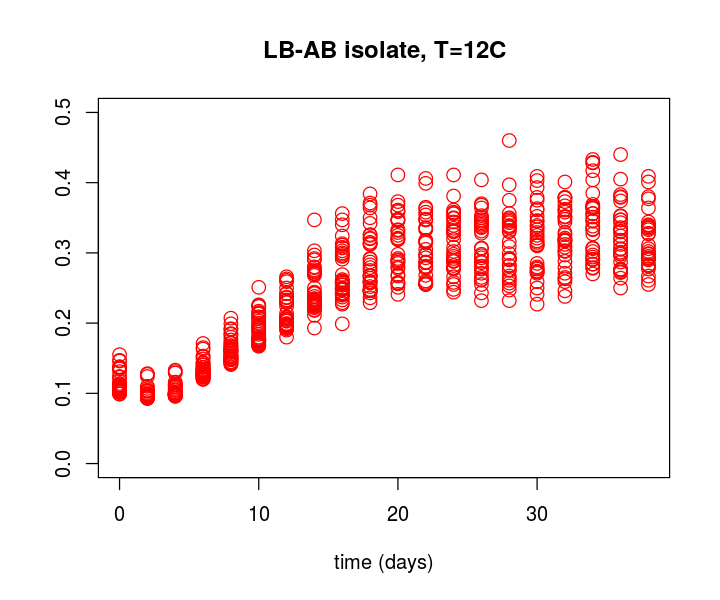

In [13]:
Temps<-seq(0,max(d2$DAY)-1, by=0.05)
mycol<-1   
my.ylim<-c(0, 0.5)
my.title<-"LB-AB isolate, T=12C"

plot(d2$DAY-1, d2$OD, xlim=c(0,max(Temps)), ylim=my.ylim,
    pch=(mycol+20),
    xlab="time (days)", ylab="",
    main=my.title,
    col=mycol+1, cex=1.5)

### Specifying the growth curve

Although logistic growth is often written as a differential equation, here we will work with the analytic solution of the model:

$$
\mu(t) = \frac{KY_0}{Y_0+(K-Y_0)\exp{(-rt)}}
$$

This gives the mean function that we want to fit. We will assume log-normal noise around this response, as the optical density is bounded to be greater than 0 and since we also have increasing variance over time (as the optical density increases).


### The thermal response model file

JAGS needs the model written as a `.txt` or `.bug` file inside the working directory. You can either make the text file directly, or create it using the `sink()` function in your R script, as follows:  

Note that the model file has two mandatory sections (the priors and the likelihood) and one optional section (derived quantiaties calculated from your fitted parameters).  

In the example below we will build the model function with the log-normal likelihood for the logistic growth function. Priors are a combination of uniform and exponential distributions. As with the normal distribution, jags uses $\tau$ to parameterize the variance of the normal distribution ($\tau = 1/(\sigma^2)$). However it can be easier to specify the prior on sigma directly. In this example we will generate posterior samples of derived quantities outside of JAGS (so you can see what this is actually doing).


#### Additional settings for jags 

Now for some additional settings/specifications for jags:

In [14]:
# Parameters to Estimate
parameters <- c('Y0', 'K', 'r', 'sigma')

# Initial values for the parameters
inits<-function(){list(
  Y0 = 0.1,
  K = 0.4,
  r = 0.1,
  sigma = rlnorm(1))}

# MCMC Settings: number of posterior dist elements = [(ni - nb) / nt ] * nc
ni <- 6000 # number of iterations in each chain
nb <- 1000 # number of 'burn in' iterations to discard
nt <- 1 # thinning rate - jags saves every nt iterations in each chain
nc <- 5 # number of chains

### Fitting the model

Now we can run jags:

In [15]:
# Pull out data columns as vectors
data <- d2 # this lets us reuse the same generic code: we only change this first line
Y <- data$OD
N <- length(Y)
t <- data$DAY

# Bundle all data in a list for JAGS
jag.data<-list(Y = Y, N = N, t = t)

# Run JAGS
OD.12C <- jags(data=jag.data, inits=inits, parameters.to.save=parameters, 
               model.file="jags-logistic.bug", n.thin=nt, n.chains=nc, n.burnin=nb, 
               n.iter=ni, DIC=T, working.directory=getwd())

module glm loaded


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 730
   Unobserved stochastic nodes: 4
   Total graph size: 1598

Initializing model



Change into "mcmc" type samples for visualization with `coda`:

In [16]:
OD.12C.mcmc<-as.mcmc(OD.12C)

#### Diagnostics

As you did in the [Traits bayesian fitting example](Traits.ipynb#Aedes-revisited-using-Bayesian-fitting), there are a number of model diagnostics that we need to check. First we want to look at the chains and confirm that they look like "fuzzy caterpillars" -- no linear/non-linear patterns across the chains, low auto-correlation, etc.

First view the fitted parameters:

In [17]:
OD.12C$BUGSoutput$summary

,mean,sd,2.5%,25%,50%,75%,97.5%,Rhat,n.eff
K,3.659490e-01,0.0055513205,3.552925e-01,3.622170e-01,3.658641e-01,3.696170e-01,3.772298e-01,1.001300,7500
Y0,9.051409e-02,0.0004844611,9.001452e-02,9.015819e-02,9.037434e-02,9.072057e-02,9.179751e-02,1.001085,16000
deviance,-2.823094e+03,6.0822395330,-2.832126e+03,-2.827586e+03,-2.824031e+03,-2.819654e+03,-2.808733e+03,1.001097,15000
r,1.051490e-01,0.0023217883,1.005654e-01,1.035754e-01,1.051368e-01,1.067121e-01,1.097114e-01,1.001249,8600
sigma,1.563601e-01,0.0041764147,1.484153e-01,1.535103e-01,1.562650e-01,1.591003e-01,1.647488e-01,1.001038,22000


Plot the chains using the coda package:

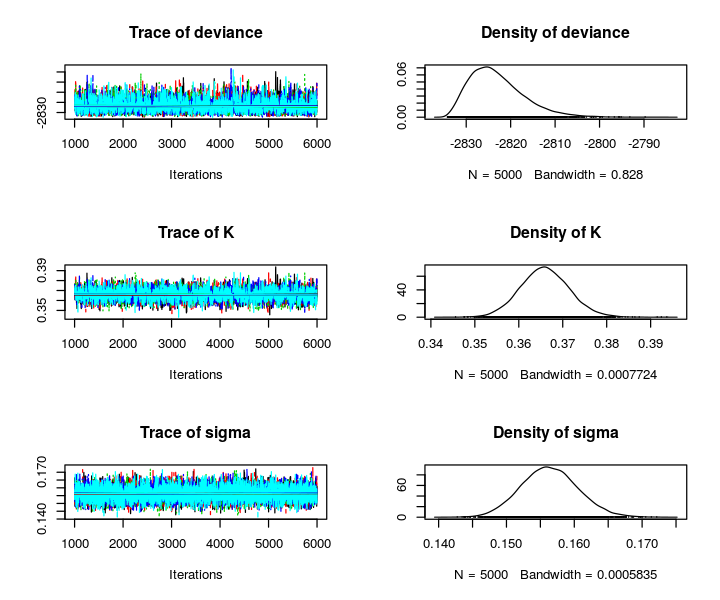

In [18]:
plot(OD.12C.mcmc[,c(1,2,4)])

We can examine the ACF of the chains as well, similarly to a time series:

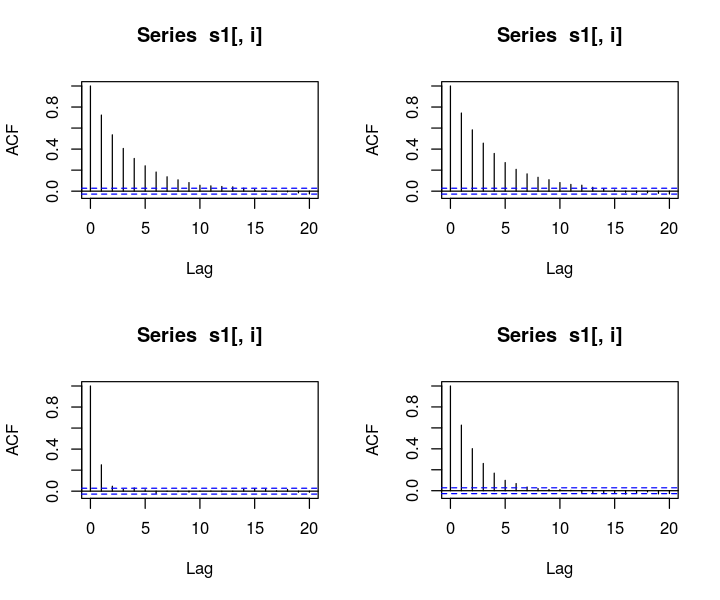

In [40]:
s1<-as.data.frame(OD.12C.mcmc[[1]])
par(mfrow=c(2,2))
for(i in 2:5) acf(s1[,i], lag.max=20)

There is still a bit of autocorrelation, but it isn't too bad. The chain for $\sigma$ is mixing best. We could reduce the autocorrelation even further by thinning the chain (i.e., change the `nt` parameter to 5 or 10).

The last important diagnostic is to compare the prior and posterior distributions. Various packages in R have bespoke functions to do this. Here we use functions that we provide in the `mcmc_utils.R` file provided on the website.

In [41]:
source("../code/mcmc_utils.R")

We also can write a function to put the samples into a convenient format for visualizing, etc:

In [42]:
samps<-NULL
for(i in 1:nc){
  samps<-rbind(samps, as.data.frame(OD.12C.mcmc[[i]]))
}

samps<-samps[,c(5,2,3,4)]

And also, we can building a list to hold all the information about the priors for each parameter:

In [43]:
priors<-list()
priors$names<-c("Y0", "K", "r","sigma")
priors$fun<-c("uniform", "uniform", "exp","exp")
priors$hyper<-matrix(NA, ncol=4, nrow=3)
priors$hyper[,1]<-c(0.09, 0.15, NA)
priors$hyper[,2]<-c(0.01,  0.6, NA)
priors$hyper[,3]<-c(1000, NA, NA) 
priors$hyper[,4]<-c(0.1, NA, NA)

Now we can plot the histograms of the posterior samples together with the prior distributions:

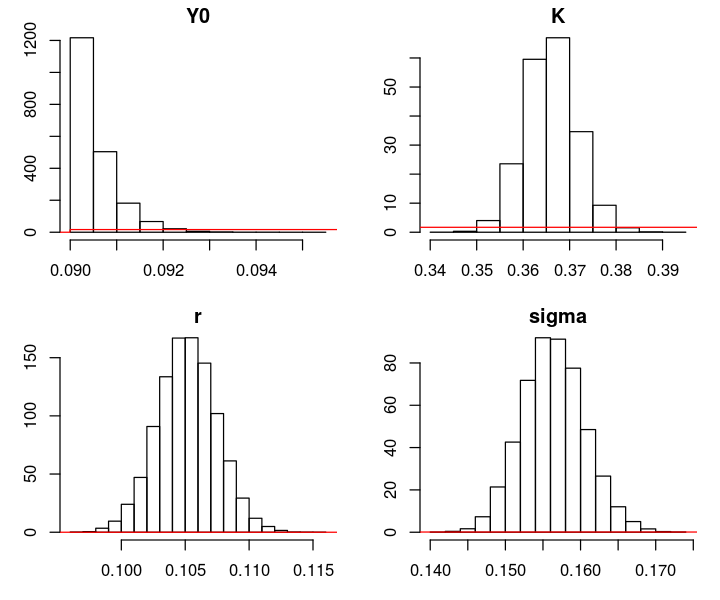

In [44]:
plot.hists(samps, my.par=c(2,2), n.hists=4, priors=priors, mai=c(0.5, 0.5, 0.25, 0.2))

The prior distribution here is very different from the posterior. These data are highly informative for the parameters of interest and are very unlikely to be influenced much by the prior distribution (although you can always change the priors to check this). However, notice that $Y_0$ (the initial condition) is truncated by the prior. This is a fairly strong prior, because we know something about the initial optical density that is typical for the esperimental set up with the density of innoculum used and with a properly calibrated set-up.

### Visualizing the joint posterior of parameters 

It's often useful to also look at the joint distbution of all of your parameters together. Of course, if you have a high dimensional posterior, rendering a 2-D representation can be difficult. Instead, the standard is to examine the pair-wise posterior distribution, for instance as follows (using the `s1` data frame we created above):

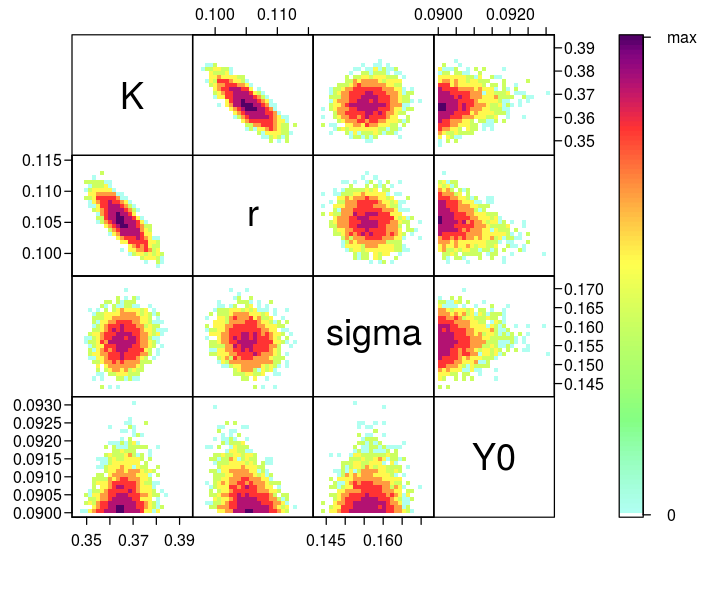

In [46]:
ipairs(s1[,2:5], ztransf = function(x){x[x<1] <- 1; log2(x)})

As you can see, estimates of $r$ and $K$ are highly correlated -- not surprising given the interplay between them in the logistic growth function. This correlation is an important feature of the system, and we use the full posterior distribution that includes this correlation when we want to build the corresponding posterior distribution of the behavior of the logistic function.

### The posterior distribution of the mean function

The final step is to check how well we are fitting the data. To do this we usually examine the posterior distribution of the mean function of our system, in this case the distribution of the logistic solution and compare this to the data. To do this, for each of our posterior samples (or a thinned subset), we plug the parameters for the $i^{\mathrm th}$ sample $\theta_i$ into our function of interest, and evaluate the function as a desired set of $x$'s. For instance, for logistic growth, we'll evaluate 
$$
\mu(t) = \frac{K_iY_{0,i}}{Y_{0,i}+(K_i-Y_{0,i})\exp{(-r_it)}}
$$
for the $i^{\mathrm th}$ set of parameters for a sequence of times, $t$. This we obtain points describing the curve $\mu_i(t)$ for each set of parameters. Here is one way to do this:

In [48]:
my.logistic<-function(t, Y0, K, r){
  return(K*Y0/(Y0+(K-Y0)*exp(-r*t)))
}

ts<-seq(0, 40, length=100)
ss<-seq(1, dim(samps)[1], by=10)
my.curves<-matrix(NA, nrow=length(ss), ncol=length(ts))

for(i in 1:length(ss)){
  my.curves[i,]<-my.logistic(t=ts, Y0=samps$Y0[i], K=samps$K[i], r=samps$r[i])
}

We can now plot all of these curves:

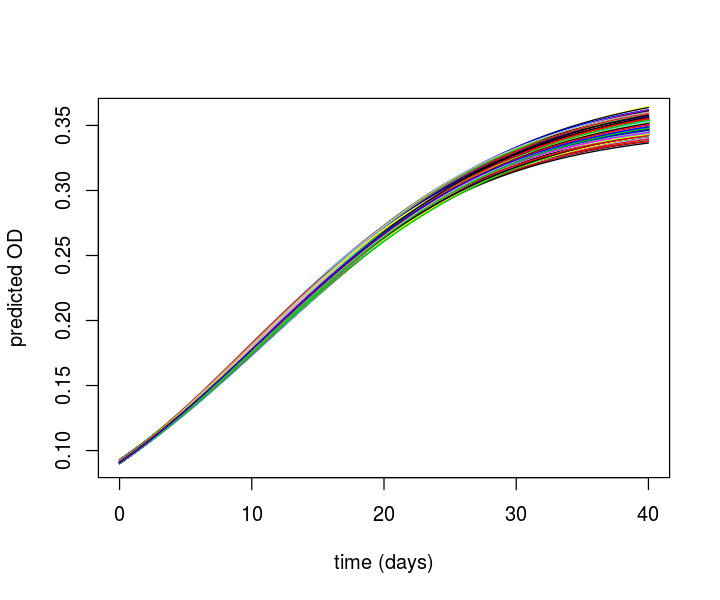

In [49]:
plot(ts, my.curves[1,], col=1, type="l", ylim=c(0.09, 0.36), 
     ylab="predicted OD", xlab="time (days)")
for(i in 2:length(ss)) lines(ts, my.curves[i,], col=i)

Then we can summarize this posterior using the `apply` function to find the mean and the (for simplicity) quantile based 95% CI:

In [50]:
m.log<-apply(my.curves, 2, mean)
l.log<-apply(my.curves, 2, quantile, probs=0.025)
u.log<-apply(my.curves, 2, quantile, probs=0.975)

For comparison, here is how to find the 95% HPD Interval across time, using the `HPDinterval` function from the `coda` package:

In [51]:
hpd.log<-NULL
for(i in 1:length(ts)){
  hpd.log<-cbind(hpd.log, as.numeric(HPDinterval(mcmc(my.curves[,i]))))
}

And plot these together with the data (in this case the HPD and quantile based intervals are indistinguishable):

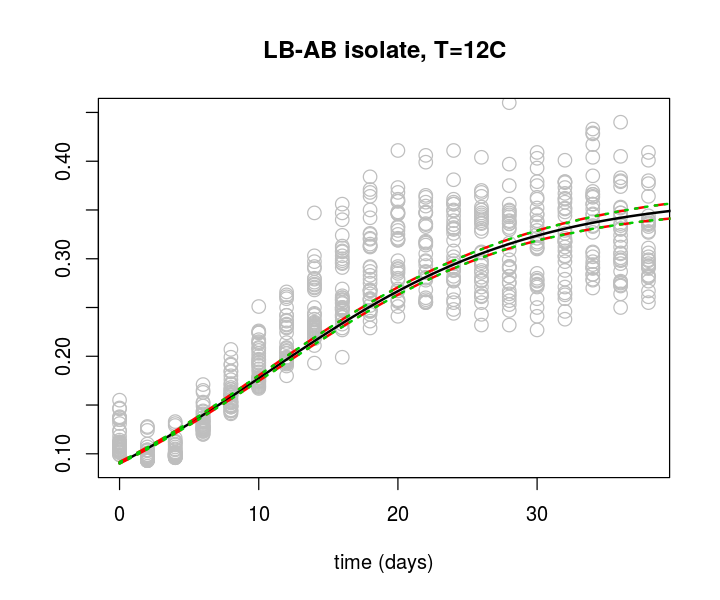

In [52]:
my.ylim<-c(0.09, 0.45)
my.title<-"LB-AB isolate, T=12C"

plot(d2$DAY-1, d2$OD, xlim=c(0,max(Temps)), ylim=my.ylim,
    pch=(mycol+20),
    xlab="time (days)", ylab="",
    main=my.title,
    col="grey", cex=1.5)
lines(ts, m.log, col=1, lwd=2)
lines(ts, l.log, col=2, lwd=2, lty=2)
lines(ts, u.log, col=2, lwd=2, lty=2)

lines(ts, hpd.log[1,], col=3, lwd=2, lty=3)
lines(ts, hpd.log[2,], col=3, lwd=2, lty=3)

Note that this only shows the uncertainty in the *mean function* -- the assumed model with log normal noise says that the observations simply have this mean. The fit is attributing the majority of the observed noise to process error rather than parameter uncertainty.

## Time Series <a id='Airline_TS'></a>

Analyses of time series is an important tool for quantifying and understanding fluctuations in vector abundance and disease incidence over time. 

Here you will perform a simple analysis of the data on airline passenger data using the time series extensions to linear regression that you learned in the [lecture](https://github.com/vectorbite/VBiTraining/tree/master/lectures). 

Also have a look at the [`VB_TS.R`](https://github.com/vectorbite/VBiTraining/tree/master/code) script first, which contains the weather example covered in the lecture.

### The Data

The data you will analyze consist of monthly numbers of international airline passengers from 1949 to 1961. These data can be found in the [`airline.csv`](https://github.com/vectorbite/VBiTraining/raw/master/data/airline.csv) file. 

In [20]:
airline <- read.csv("../data/airline.csv")

First plot the data:

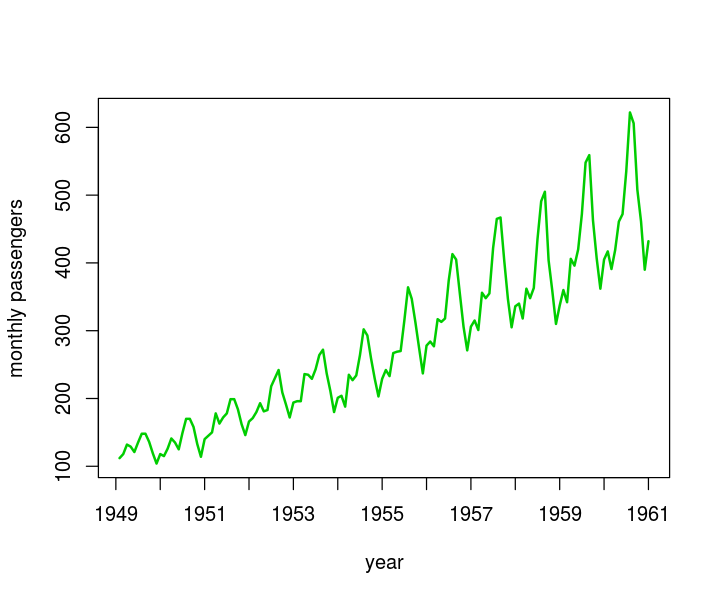

In [21]:
plot(airline$Passengers, xlab="year", ylab="monthly passengers", type="l", col=3, lwd=2, xaxt="n")
axis(1, at=(0:12)*12, labels=1949:1961)

Notice that this involves a somewhat different approach toward adding axis labels than usual. *What does `at="n"` mean? What does the axis function do?* (Check the help doc: `?axis`)

Next, we use the `acf` function to plot the auto-correlation function of the passengers data:

In [22]:
## put the acf function here


*From the two plots above, what things do you notice about the data? What transforms might you need to take of the data? What kinds of covariates might you need to add in?*

Re-plot the from data above using a log transform of the response (passenger):

In [23]:
## plot code here

Now it's time to build a data frame to hold the data. This is a good habit to get in to when you are building models for data that include transforms and possibly multiple lags, etc. 

First we make a time covariate:

In [24]:
t <- 2:nrow(airline)

Now, into the data frame, add the following covariates:

1. logY: log of the number of passengers 
2. logYpast: this is your auto-regressive term, the log of the passengers from the previous month
3. t: month number
4. sin12: sine terms with period of 12 months
5. cos12: cosine term with period of 12 months

In [25]:
YX <- data.frame(logY=log(airline$Passengers[2:144]), 
                 logYpast=log(airline$Passengers[1:143]), t=t,
                 sin12=sin(2*pi*t/12), cos12=cos(2*pi*t/12))

In [26]:
## your fitted model and the summary go here

Fit a linear model with logY as the response and the other 4 components as predictors. Look at the summary of the fit.


*Are all of the predictors significant? What is the $R^2$ of your regression?*

Next, we want to plot the data along with the prediction (aka the fit). I've plotted the data on a log scale (drawn with a dotted line).  Use the "lines" function to overlay the FITTED values from your regression (e.g., if your regression model was called "reg" you want to plot reg$fitted vs t) as a solid line in another color. This solid line is your prediction. Update the legend to reflect your additional line.

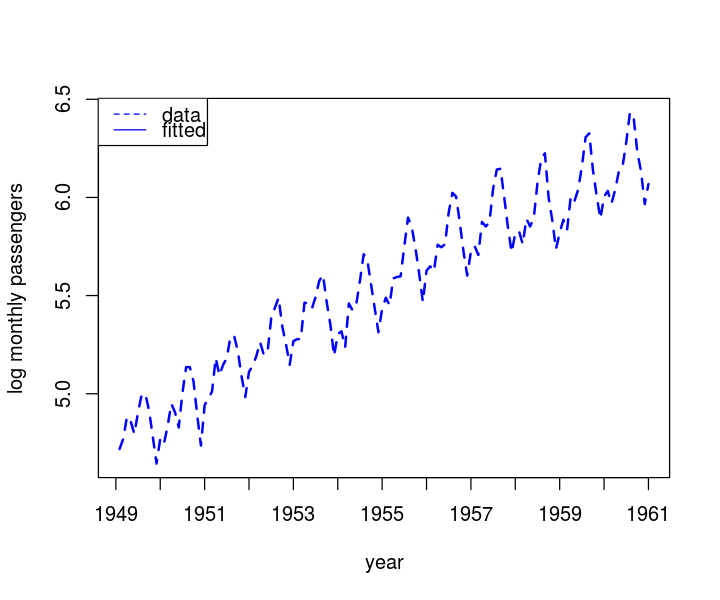

In [27]:
plot(log(airline$Passengers), xlab="year",
     ylab="log monthly passengers", type="l", col=4, lty=2,
     xaxt="n", lwd=2)
axis(1, at=(0:12)*12, labels=1949:1961)

## add in the line here

legend("topleft", legend=c("data", "fitted"), lty=c(2,1), col=c(4,4)) ## update the legend


The difference between the solid and dotted lines at each month are your residuals across time. As always, we want to also look at our residuals explicitly to see if we're doing a good job of explaining things. For TS we primarily look at residuals across time, and the ACF of our residuals. So make those two plots here. 

In [28]:
par(mfrow=c(1,2))

## residuals plotted across time

## acf plot of the residuals

*How do these look? What do you notice about the residuals, esp the ACF?*

It turns out that there is a month effect that we're missing. Here is one way to look at it (note we have to index by t so that everything lines up properly):

In [29]:
## this command assumes that your fitted model is called mod1. You'll need to change it to your object

## boxplot(mod1$resid ~ airline$Month[t], xlab="month",
##        ylab="residuals", col=7)

Residuals in months with lots of school holidays (March, summer, December) are consistantly high. Let's create a dummy variable called "holidays" that tells whether a particular passenger record is for a month that has lots of holidays.

In [30]:
YX$holidays <- airline$Month[t] %in% c(3,6,7,8,12)

Fit a new lm that adds this holiday variable on to what you had before, and then re-examine the residuals, including by month.

In [31]:
## new fitted model and summary here

## plot of data + model fit here
par(mfrow=c(1,2))
## residuals plotted across time

## acf plot of the residuals

## boxplot of residuals by month


### Model Comparison

Now you have 2 nested models. Because they are nested, we can compare them in two ways. First I do a partial F-test. The idea behind the F-test is that it looks at the difference in the $R^2$ value between the two models and determines whether or not this difference is large enough to warrent the additional covariates. If we use the "anova" function in R and provide both fittend model objects as arguments, it will automatically perform a partial F-test. Note: you will need to replace mod1 and mod2 with the names of your model objects.

In [32]:
## partial F test: anova(mod1, mod2)

*Based on these what model would you choose and why?*

We can also compare the models via BIC (the Bayesian Information Criterion) and the approximate relative model probabilities based on the BICs. Note that we can use BIC/model probabilities to compare between models even if the models are not nested, as long as the response being modeled is the same in each case. Note: you will need to replace mod1 and mod2 with the names of your model objects.

In [33]:
n<-length(YX$logY)-1
##bics<-c(mod1=extractAIC(mod1, k=log(n))[2],
##        mod2=extractAIC(mod2, k=log(n))[2])

##ebics<-exp(-0.5*(bics-min(bics)))

##probs<-ebics/sum(ebics)


##rbind(round(bics, 5), round(probs, 5))

*Which model is the best via BIC? Does this jive with what the partial F-test told you? What is the $R^2$ for your best model. Based on this model selection, $R^2$ and what you saw in the residuals for this model, do you feel satisfied that your model is capturing the patterns in the data? Would you want to go back and fit anything else?*

### Practical: A Vector abundance example 

Now how about an analysis of some actual vector abundance data. We will use *Aedes aegypti* abundances from light traps from various locations in Manatee County, Florida. This dataset can be downloaded from the [VecDyn database](https://vectorbiteonlineplatform.pythonanywhere.com/VectorBiteDataPlatform/default/). You will need ti register first. The same dataset is also available on the workshop [git repository](https://github.com/vectorbite/VBiTraining) (file called [`vecdyn_manatee_county_a.aegypti.csv`](https://github.com/vectorbite/VBiTraining/raw/master/data/vecdyn_manatee_county_a.aegypti.csv)). 

* Perform a time-series analysis as you did above using these data and write it as an indepndent, self-sufficient R script that produces all the plots in a reproducible workflow when sourced. 


## Time Series Challenge

Just like the [traits challenge](Traits.ipynb#The-Traits-Challenge), will work in groups to tackle this second "Challenge" problem. 

The main objective is to perform a time series analysis on some a disease incidence dataset and compare different models. Your goal is not just to practise model fitting and selection, but also to extract biological insights from it. 

**_You will present the results of your analysis and biological inferences during the group discussion session_**. 

Good luck!


### The Data

The data consist of time series of dengue case data from San Juan, Puerto Rico together with environmental data for each location across a number of transmission seasons. The file is `combined_sanjuan_new.csv`. Detailed descriptions of the data are available [here]( http://dengueforecasting.noaa.gov/). 

To operate effectively, health departments must be able to predict weekly cases, as this will correspond to hospital demand and resources. 

Your task is to provide a fitted model for forecasting weekly total dengue cases in San Juan. You can use autoregressive components and sine/cosine trends to build your model. You can also use the environmental covariates. Remember that you want to be able to predict into the future so you will only include lagged predictors into your prediction model. Below we suggest a series of steps for the analysis and then you'll have the opportunity to develop your own model(s) and choose which components that you want to keep. We'll compare models during the group discussion. 

Here is some code to get you started.

First read in the data and look at the summary:

In [34]:
sanjuan<-read.csv(file="../data/combined_sanjuan_new.csv")
head(sanjuan)
summary(sanjuan)

season,season_week,year_week,week_start_date,weekID,monthID,year,denv1_cases,denv2_cases,denv3_cases,⋯,tmin,tmax,prec,dtr,tavg,nino12,nino34,soi,pop,adjpop
1990/1991,1,18,4/30/1990,199018,199004,1990,0,0,0,⋯,296.4,300.7,16.64,2.385714,298.2643,25.22,28.93,0.3,2217968,2226511
1990/1991,2,19,5/7/1990,199019,199005,1990,0,0,0,⋯,297.3,300.9,22.90,2.242857,298.9929,24.05,28.96,2.0,2217968,2227014
1990/1991,3,20,5/14/1990,199020,199005,1990,0,0,0,⋯,297.0,301.1,18.50,2.442857,299.0643,24.05,28.96,2.0,2217968,2227516
1990/1991,4,21,5/21/1990,199021,199005,1990,0,0,0,⋯,297.5,301.9,7.30,3.085714,299.6857,24.05,28.96,2.0,2217968,2228019
1990/1991,5,22,5/28/1990,199022,199005,1990,0,0,0,⋯,298.1,302.4,25.19,2.200000,299.8714,24.05,28.96,2.0,2217968,2228521
1990/1991,6,23,6/4/1990,199023,199006,1990,1,0,0,⋯,297.7,301.1,44.70,1.900000,299.0929,22.68,28.94,0.5,2217968,2229024


       season     season_week      year_week      week_start_date
 1990/1991: 52   Min.   : 1.00   Min.   : 1.00   10/1/1990:  1   
 1991/1992: 52   1st Qu.:13.75   1st Qu.:13.75   10/1/1991:  1   
 1992/1993: 52   Median :26.50   Median :26.50   10/1/1993:  1   
 1993/1994: 52   Mean   :26.50   Mean   :26.50   10/1/1994:  1   
 1994/1995: 52   3rd Qu.:39.25   3rd Qu.:39.25   10/1/1995:  1   
 1995/1996: 52   Max.   :52.00   Max.   :52.00   10/1/1997:  1   
 (Other)  :676                                   (Other)  :982   
     weekID          monthID            year       denv1_cases    
 Min.   :199018   Min.   :199004   Min.   :1990   Min.   : 0.000  
 1st Qu.:199505   1st Qu.:199501   1st Qu.:1995   1st Qu.: 0.000  
 Median :199944   Median :199910   Median :1999   Median : 0.000  
 Mean   :199959   Mean   :199939   Mean   :1999   Mean   : 1.389  
 3rd Qu.:200430   3rd Qu.:200407   3rd Qu.:2004   3rd Qu.: 1.000  
 Max.   :200917   Max.   :200904   Max.   :2009   Max.   :27.000  
   

Next plot the response output, `total_cases` across time:

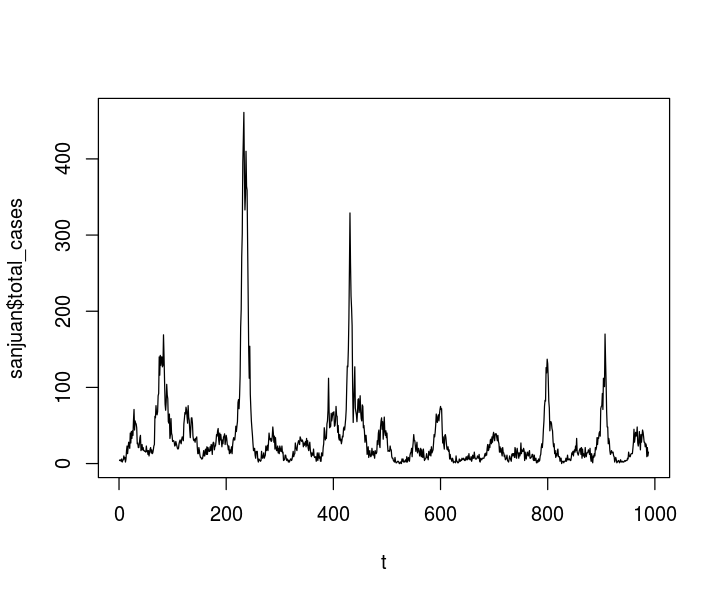

In [35]:
t<-seq(1, length(sanjuan$total_cases))
plot(t, sanjuan$total_cases, type="l")

It may be a little hard to tell, but when you have a lot of cases, the variance is higher, too. As in the [airline time series example](#Airline_TS), we need to make a data transformation. However, we have zeros in the total cases, so instead of a log we'll use a square-root:

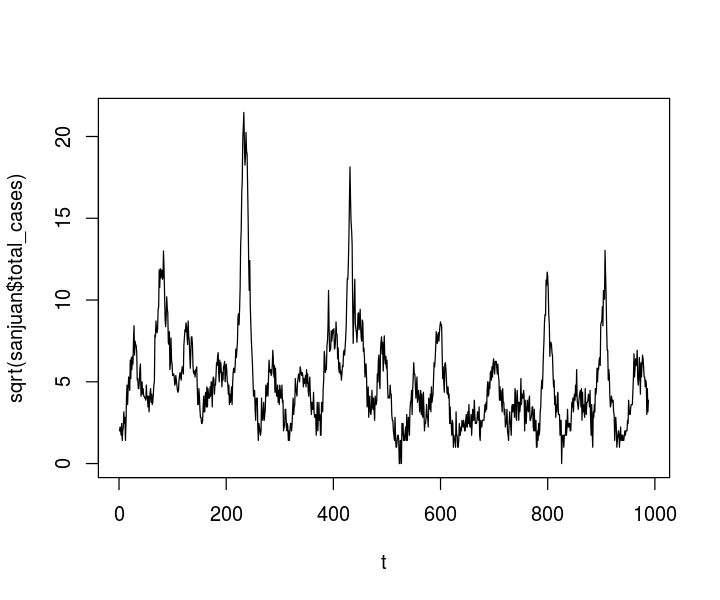

In [36]:
t<-seq(1, length(sanjuan$total_cases))
plot(t, sqrt(sanjuan$total_cases), type="l")

And the ACF plot:

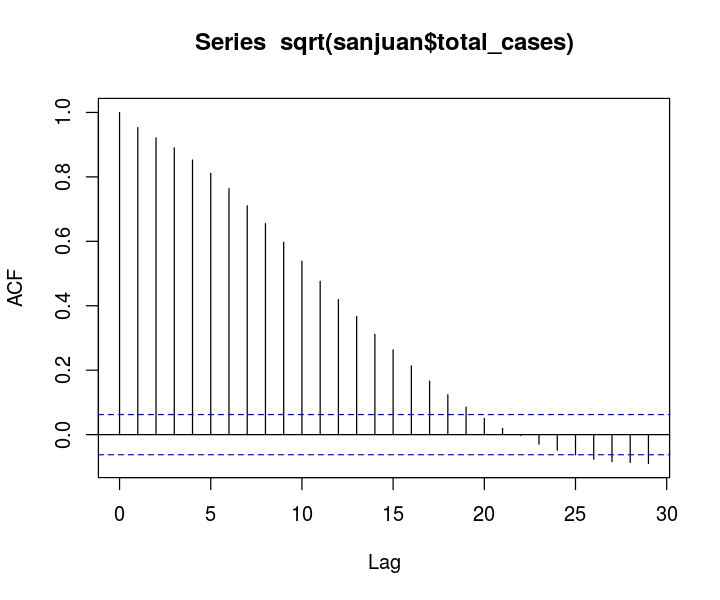

In [37]:
acf(sqrt(sanjuan$total_cases))

*What do you notice about the ACF? What does this tell you about terms you might want to include in your regression analysis?*

If you were to look at your covariates, you'd notice that there's a lot of correlation between things like average and max or min temperature and population and the adjusted population. Thus, we don't want to include absolutely everything here. Instead, we're going to select a subset of covariates here. As always, it's a good idea to build a new data frame with the subset of covariates that you want to explore. We start with the sqrt of cases as your response, AR1 of the sqrt response, a trend, and sine/cosine with a 52 week period together with a subset of the environmental covariates at 1 week lags. (As an aside, temperature, precipitation, etc, will be correlated with the sine/cosine terms.)

In [38]:
n<-max(t)
YX <- data.frame(sqrty=sqrt(sanjuan$total_cases)[2:n],
                 sqrty.m1=sqrt(sanjuan$total_cases)[1:(n-1)],
                 t=t[2:n],
                 sin1=sin((2:n)*2*pi/52),
                 cos1=cos((2:n)*2*pi/52),
                 season=sanjuan$season[2:n],
                 w=sanjuan$season_week[2:n],
                 lpop.m1=log(sanjuan$adjpop+1)[1:(n-1)],
                 lp.m1=log(sanjuan$prec+1)[1:(n-1)],
                 tavg.m1=sanjuan$tavg[1:(n-1)],
                 ndvi45.m1=sanjuan$NDVI.18.45.66.14.[1:(n-1)],
                 ndvi50.m1=sanjuan$NDVI.18.50..66.14.[1:(n-1)],
                 nino12.m1=sanjuan$nino12[1:(n-1)],
                 soi.m1=sanjuan$soi[1:(n-1)])

### Guidelines

We suggest the following steps for your analysis. 

**(1) Hypotheses**

Before you start, think about which things you expect to be good predictors of dengue transmission. Think of 2 or 3 hypotheses and write down a (linear) model to represent the mathematical form of the hypothesis.

**(2) Fitting and analyzing a first model**

Fit a linear model to the square-root response with the trend, and sine/cosine components, ONLY. Then you'll evaluate the model. Following the examples in the lecture, plot the residuals over time and the ACF of the residuals. Also plot the data together with the predicted values (e.g., the _fitted_ values from your model). Examine your summary -- are all of the coefficiants significantly different from zero; what is your R$^2$ value? Based on the combination of residual diagnositcs and summaries, are you satisfied with this model?

**(3) Building a comparison model**

Build a second model by adding in the AR-1 component. Again examine your summaries, residual diagnostics, and predictions. How do you think this model compares to the first one? You may also want to try building boxplots of residuals by week in the season and see if there are any patterns, similarly to the airline example.

**(4) Including environmental components**

By trial and error (or if you know another way, such as the step function) try to build a better model that includes at least one environmental covariate while staying parsimonious. Again check your diagnostics, etc.

**(5) Comparing models**

Now compare your 3 models via BIC (optional: calculate the relative model probabilities). Which comes out on top? Is this what you expected? What biological insights have you gained?


**_Extra challenge_**

For convenience we simply chose a lag of 1 week when we built the data set. However, the lag time between an infected human, and another human getting  infected is likely to be multiple weeksbecause of the various incubation and development times in the human and the mosquito. To examine the lags at which the covariates are most related to the response, we can use the cross-correlation function (ccf). For instance:b

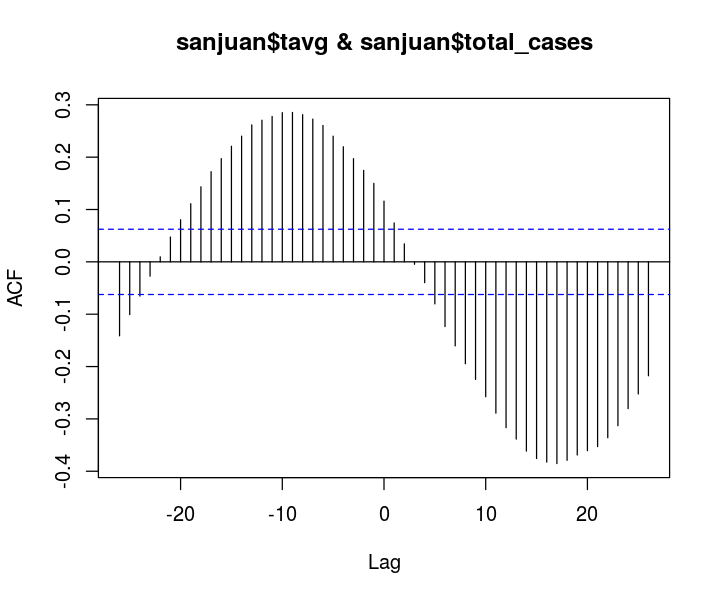

In [39]:
ccf(sanjuan$tavg, sanjuan$total_cases)

This indicates that the temperature about 10 weeks back is more correlated with the incidence than the temperature 1 week ago. 

Plot a few other ccfs, choose some alternative lags, and build a NEW dataset with these lagged variables. Then build a few models (perhaps starting again from the simple versions without environmental covariates), and compare them. Does including the extra information about lags seem to improve fit?

## Readings & Resources <a id='Readings'></a>

* Motulsky, Harvey, and Arthur Christopoulos. Fitting models to biological data using linear and nonlinear regression: a practical guide to curve fitting. OUP USA, 2004.